# Preprocess Data

In [1]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade
#!pip install Keras-Preprocessing

In [2]:
import tensorflow as tf
print(tf.__version__)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.16.1


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwfen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [6]:
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
df.shape

(1600000, 6)

In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 125 ms
Wall time: 254 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

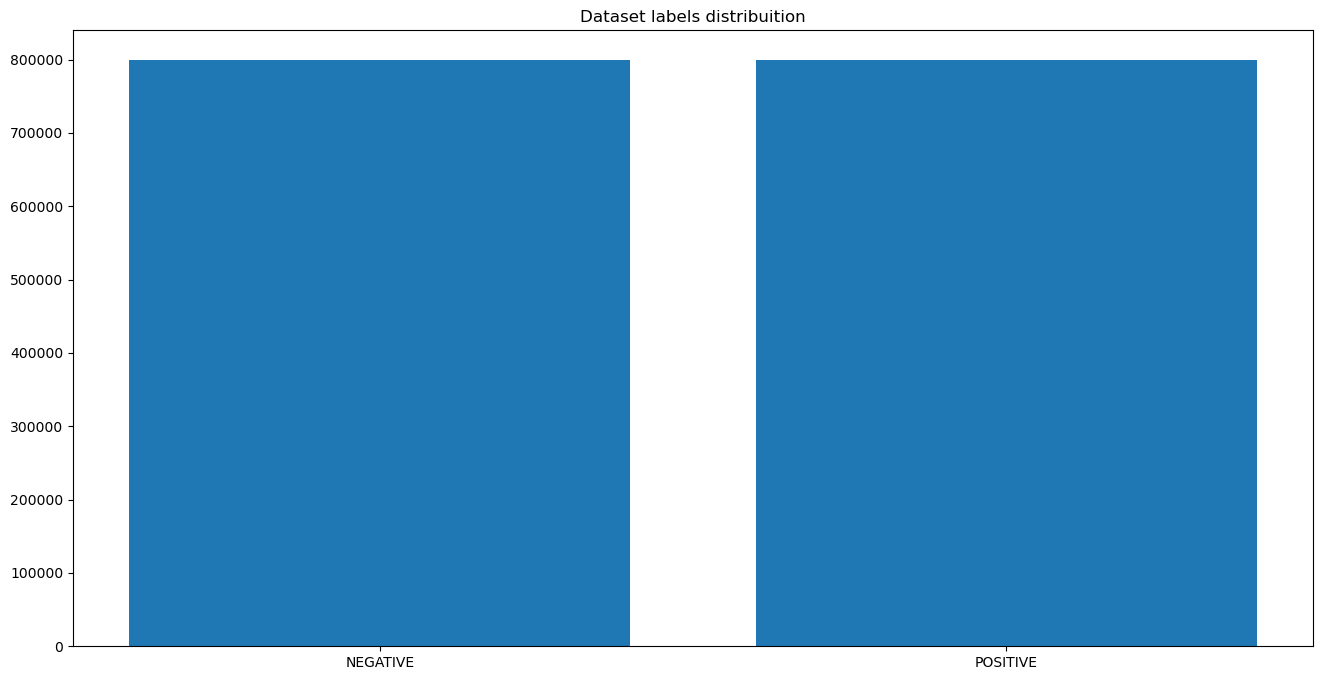

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'\b\w{1,2}\b', '', text) # removes single characters and short words
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())    
    word_counts = Counter(text.split())    
    min_freq = 4  # Example threshold
    tokens = []
    for token in text.split():
        if word_counts[token] < min_freq:
            pass
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x, True))

CPU times: total: 1min 18s
Wall time: 2min 29s


### WordCloud

In [18]:
df_negative = df[df['target'] == 'NEGATIVE']
df_positive = df[df['target'] == 'POSITIVE']

In [20]:
# Define a custom preprocessing function
def preprocess(text, remove_unwanted=True, unwanted_terms=None):
    # Convert text to lowercase
    text = text.lower()
    # Remove unwanted terms
    if remove_unwanted:
        #unwanted_terms = ['quot', 'amp', 'lol', 'etc']
        pattern = r'\b(?:' + '|'.join(unwanted_terms) + r')\b'
        text = re.sub(pattern, '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

C:\Users\kwfen\AppData\Local\Temp\ipykernel_22036\823717131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative['text'] = df_negative['text'].apply(lambda x: preprocess(x, True, unwanted_terms))


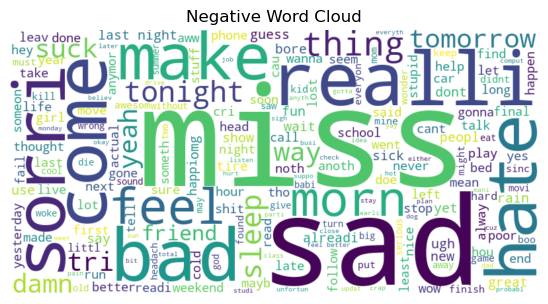

In [28]:
unwanted_terms = ['quot', 'amp', 'lol', 'etc', 'love', 'today','one','right','work','think','time','still',
                  'got','wa','ha','good','look','twitter','guy','haha','man','go','see','tweet','wish',
                 'want','need','know','start','back','week','even','watch','day','well','much','fuck',
                 'though','home','thank','hope']
df_negative['text'] = df_negative['text'].apply(lambda x: preprocess(x, True, unwanted_terms))
negative_text = ' '.join(df_negative['text'])

negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
# Display the word clouds


In [30]:
unwanted_terms = ['quot', 'amp', 'lol', 'etc']
df_positive['text'] = df_positive['text'].apply(lambda x: preprocess(x, True, unwanted_terms))
positive_text = ' '.join(df_positive['text'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)


C:\Users\kwfen\AppData\Local\Temp\ipykernel_22036\1394634908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['text'] = df_positive['text'].apply(lambda x: preprocess(x, True, unwanted_terms))


(-0.5, 799.5, 399.5, -0.5)

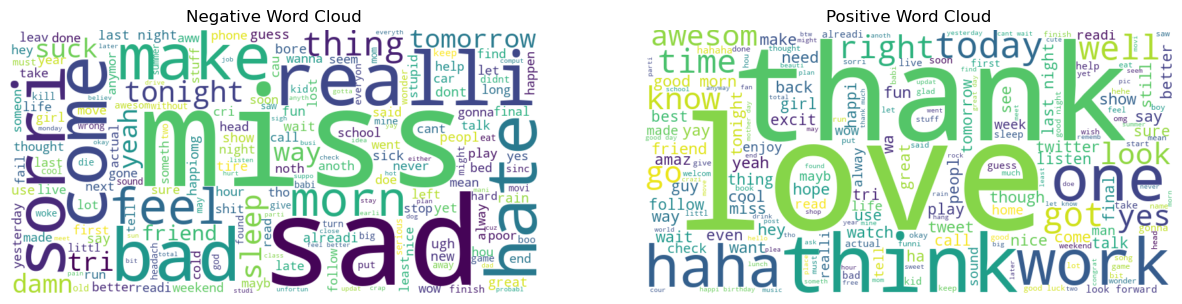

In [33]:
# Display the word clouds
plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Word Cloud')
plt.axis('off')

### Split train and test

In [129]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [130]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 1.19 s
Wall time: 3.07 s


In [131]:
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
W2V_WORKERS = 8
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=W2V_WORKERS)

2024-06-14 18:45:10,566 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2024-06-14T18:45:10.566543', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [132]:
w2v_model.build_vocab(documents)

2024-06-14 18:45:10,597 : INFO : collecting all words and their counts
2024-06-14 18:45:10,598 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-14 18:45:10,608 : INFO : PROGRESS: at sentence #10000, processed 68528 words, keeping 11036 word types
2024-06-14 18:45:10,618 : INFO : PROGRESS: at sentence #20000, processed 136319 words, keeping 17015 word types
2024-06-14 18:45:10,629 : INFO : PROGRESS: at sentence #30000, processed 203652 words, keeping 21740 word types
2024-06-14 18:45:10,638 : INFO : PROGRESS: at sentence #40000, processed 272067 words, keeping 25945 word types
2024-06-14 18:45:10,647 : INFO : PROGRESS: at sentence #50000, processed 339467 words, keeping 29863 word types
2024-06-14 18:45:10,657 : INFO : PROGRESS: at sentence #60000, processed 407032 words, keeping 33564 word types
2024-06-14 18:45:10,666 : INFO : PROGRESS: at sentence #70000, processed 474667 words, keeping 37006 word types
2024-06-14 18:45:10,675 : INFO : PROGRESS: at s

2024-06-14 18:45:11,311 : INFO : PROGRESS: at sentence #720000, processed 4896567 words, keeping 167828 word types
2024-06-14 18:45:11,321 : INFO : PROGRESS: at sentence #730000, processed 4964100 words, keeping 169411 word types
2024-06-14 18:45:11,332 : INFO : PROGRESS: at sentence #740000, processed 5032145 words, keeping 170884 word types
2024-06-14 18:45:11,342 : INFO : PROGRESS: at sentence #750000, processed 5099895 words, keeping 172368 word types
2024-06-14 18:45:11,352 : INFO : PROGRESS: at sentence #760000, processed 5168033 words, keeping 173903 word types
2024-06-14 18:45:11,364 : INFO : PROGRESS: at sentence #770000, processed 5236508 words, keeping 175432 word types
2024-06-14 18:45:11,373 : INFO : PROGRESS: at sentence #780000, processed 5303593 words, keeping 176925 word types
2024-06-14 18:45:11,384 : INFO : PROGRESS: at sentence #790000, processed 5372086 words, keeping 178493 word types
2024-06-14 18:45:11,393 : INFO : PROGRESS: at sentence #800000, processed 544078

In [133]:
# Get the keys from the model's dictionary (the vocabulary)
words = w2v_model.wv.index_to_key

# Calculate vocabulary size
vocab_size = len(words)

print("Vocabulary size:", vocab_size)

Vocabulary size: 246313


In [134]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-06-14 18:45:14,241 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 246313 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2024-06-14T18:45:14.241992', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
2024-06-14 18:45:15,272 : INFO : EPOCH 0 - PROGRESS: at 38.50% examples, 3056339 words/s, in_qsize 16, out_qsize 1
2024-06-14 18:45:16,278 : INFO : EPOCH 0 - PROGRESS: at 78.57% examples, 3116555 words/s, in_qsize 16, out_qsize 0
2024-06-14 18:45:16,804 : INFO : EPOCH 0: training on 8698121 raw words (7969545 effective words) took 2.5s, 3142535 effective words/s
2024-06-14 18:45:17,823 : INFO : EPOCH 1 - PROGRESS: at 40.56% examples, 3223119 words/s, in_qsize 16, out_qsize 0
2024-06-14 18:45:18,824 : INFO : EPOCH 1 - PROGRESS: at 80.30% examples, 3193615 wor

2024-06-14 18:46:08,919 : INFO : EPOCH 21 - PROGRESS: at 80.30% examples, 3198792 words/s, in_qsize 16, out_qsize 3
2024-06-14 18:46:09,365 : INFO : EPOCH 21: training on 8698121 raw words (7969443 effective words) took 2.4s, 3256173 effective words/s
2024-06-14 18:46:10,383 : INFO : EPOCH 22 - PROGRESS: at 40.10% examples, 3188920 words/s, in_qsize 14, out_qsize 1
2024-06-14 18:46:11,386 : INFO : EPOCH 22 - PROGRESS: at 81.00% examples, 3220024 words/s, in_qsize 15, out_qsize 0
2024-06-14 18:46:11,864 : INFO : EPOCH 22: training on 8698121 raw words (7970263 effective words) took 2.5s, 3209011 effective words/s
2024-06-14 18:46:12,888 : INFO : EPOCH 23 - PROGRESS: at 41.25% examples, 3264136 words/s, in_qsize 15, out_qsize 0
2024-06-14 18:46:13,894 : INFO : EPOCH 23 - PROGRESS: at 81.11% examples, 3210821 words/s, in_qsize 15, out_qsize 0
2024-06-14 18:46:14,356 : INFO : EPOCH 23: training on 8698121 raw words (7968469 effective words) took 2.5s, 3218832 effective words/s
2024-06-14 1

CPU times: total: 50.9 s
Wall time: 1min 20s


(255026363, 278339872)

In [135]:
# Find the most similar words to a given word
similar_words = w2v_model.wv.most_similar("love")

# Print the similar words
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

amaz: 0.6663435697555542
awesom: 0.6315411329269409
luv: 0.5972509980201721
perfect: 0.5858340263366699
remind: 0.5607200264930725
great: 0.5449656248092651
favorit: 0.5446003675460815
enjoy: 0.5339847207069397
loooov: 0.5302038788795471
rock: 0.5300450921058655


### Tokenize Text

In [136]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 246314
CPU times: total: 4.22 s
Wall time: 8.8 s


In [137]:
num_words = len(tokenizer.word_index)
print(f'Number of unique words: {num_words}')

Number of unique words: 246313


In [138]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 5.86 s
Wall time: 11.5 s


### Label Encoder 

In [24]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [25]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [29]:
def check_and_fix_out_of_bounds(x_train, max_value):
    num_out_of_bounds = np.sum(x_train >= max_value)
    print(f"Number of out-of-bounds values: {num_out_of_bounds}")
    x_train[x_train >= max_value] = max_value - 1
    return x_train

x_train = check_and_fix_out_of_bounds(x_train, 5000)

Number of out-of-bounds values: 1421709


### Dump x_train, x_test, y_train, y_test to files

In [28]:
# Assuming x_train, y_train, x_test, and y_test are your numpy arrays
folder = 'input/'
np.save('input/x_train.npy', x_train)
np.save('input/y_train.npy', y_train)
np.save('input/x_test.npy', x_test)
np.save('input/y_test.npy', y_test)